In [1]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import os, warnings 
import glob
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

PATH = '../input/food101/food-101/images'
SEED = 42
warnings.filterwarnings('ignore')

2022-08-21 20:11:39.583135: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
def set_global_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONASHSEED'] = str(seed)
    os.environ['TF_DETERMENISTIC_OPS'] = '1'

set_global_seed(SEED)

In [3]:
# load list of all images
train = pd.DataFrame(pd.read_csv('../input/food101/food-101/meta/train.txt', sep='/', 
                                 header=None, names=['class_name', 'img_name']))
test = pd.DataFrame(pd.read_csv('../input/food101/food-101/meta/test.txt', sep='/', 
                                header=None, names=['class_name', 'img_name']))

In [4]:
# put class name along with each image name
train['img_name'] = train['img_name'].apply(lambda x: str(x) + '.jpg')
test['img_name'] = test['img_name'].apply(lambda x: str(x) + '.jpg')

train.sample(5)

,class_name,img_name
18388,clam_chowder,2871728.jpg
47035,macaroni_and_cheese,3545493.jpg
72532,tacos,3633647.jpg
47016,macaroni_and_cheese,3453546.jpg
46354,lobster_roll_sandwich,69108.jpg


In [5]:
# transform each class name into numerical code
train['class_name'] = train['class_name'].astype('category')
train['label'] = train['class_name'].cat.codes

test['class_name'] = test['class_name'].astype('category')
test['label'] = test['class_name'].cat.codes

test.sample(5)

,class_name,img_name,label
23998,sushi,988559.jpg,95
18927,pho,3598157.jpg,75
3324,caprese_salad,1971011.jpg,13
21129,risotto,2670349.jpg,84
10024,french_fries,153823.jpg,40


In [6]:
# set number of TFRecord files to create
TRAIN_VAL_FILES = 30
TRAIN_FILES = 24
VALID_FILES = 6
TEST_FILES = 5

# distribute images by files to which they will be written
def get_folds(dataset, FILES):
    folds = StratifiedKFold(n_splits=FILES, shuffle=True, random_state=SEED)
    dataset['file'] = -1

    for fold_n, (ds_idx, val_ds_idx) in enumerate(folds.split(dataset, dataset['label'])):
        # print('File %s has %s samples' % (fold_n + 1, len(val_ds_idx)))
        dataset['file'].loc[val_ds_idx] = fold_n
    return dataset

train = get_folds(train, TRAIN_VAL_FILES)
test = get_folds(test, TEST_FILES)

train.sample(5)

,class_name,img_name,label,file
57304,pizza,2487039.jpg,76,28
10114,caprese_salad,2756777.jpg,13,24
13212,cheese_plate,3182251.jpg,16,10
22611,deviled_eggs,1486281.jpg,30,17
4110,beet_salad,2769513.jpg,5,29


In [7]:
# separate train files from validation files and update validation files count to start from 0
filt = (train['file'] > 23)
valid = train.loc[filt]
train = train.loc[~filt]
valid['file'] = valid['file'].apply(lambda x: x - 24)
valid.sample(10)

,class_name,img_name,label,file
70522,strawberry_shortcake,1166911.jpg,94,1
37344,grilled_cheese_sandwich,53344.jpg,49,0
30847,french_onion_soup,1337073.jpg,41,1
75204,waffles,1915099.jpg,100,4
22810,deviled_eggs,243148.jpg,30,4
12773,cheese_plate,1101209.jpg,16,0
57715,pizza,893644.jpg,76,4
32619,fried_calamari,2442213.jpg,43,4
72973,takoyaki,2066592.jpg,97,4
62722,red_velvet_cake,2985875.jpg,83,4


In [8]:
# helper functions
def image_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(value).numpy()])
    )

def int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def create_example(image, label):
    feature = {
        "image": image_feature(image),
        "label": int64_feature(label),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def parse_tfrecord_fn(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    return example

In [9]:
# create TFRecord files
def create_tfrec(dataset, n_files, name=None):
    for tfrec_num in range(n_files):
        print('\nWriting %i out of %i TFRecords...'%(tfrec_num+1, n_files))
        samples = dataset[dataset['file'] == tfrec_num]
        n_samples = len(samples)
        print(n_samples)
        with tf.io.TFRecordWriter(
            str(name) + '_%.2i-%i.tfrec'%(tfrec_num, n_samples)
        ) as writer:
            for row in samples.itertuples():
                label = row.label
                img_path = os.path.join(PATH, row.class_name, row.img_name)
                image = tf.io.decode_jpeg(tf.io.read_file(img_path))
                example = create_example(image, label)
                writer.write(example.SerializeToString())

In [20]:
create_tfrec(train, TRAIN_FILES, 'train')


Writing 1 out of 24 TFRecords...
2525

Writing 2 out of 24 TFRecords...
2525

Writing 3 out of 24 TFRecords...
2525

Writing 4 out of 24 TFRecords...
2525

Writing 5 out of 24 TFRecords...
2525

Writing 6 out of 24 TFRecords...
2525

Writing 7 out of 24 TFRecords...
2525

Writing 8 out of 24 TFRecords...
2525

Writing 9 out of 24 TFRecords...
2525

Writing 10 out of 24 TFRecords...
2525

Writing 11 out of 24 TFRecords...
2525

Writing 12 out of 24 TFRecords...
2525

Writing 13 out of 24 TFRecords...
2525

Writing 14 out of 24 TFRecords...
2525

Writing 15 out of 24 TFRecords...
2525

Writing 16 out of 24 TFRecords...
2525

Writing 17 out of 24 TFRecords...
2525

Writing 18 out of 24 TFRecords...
2525

Writing 19 out of 24 TFRecords...
2525

Writing 20 out of 24 TFRecords...
2525

Writing 21 out of 24 TFRecords...
2525

Writing 22 out of 24 TFRecords...
2525

Writing 23 out of 24 TFRecords...
2525

Writing 24 out of 24 TFRecords...
2525


In [21]:
create_tfrec(valid, VALID_FILES, 'valid')


Writing 1 out of 6 TFRecords...
2525

Writing 2 out of 6 TFRecords...
2525

Writing 3 out of 6 TFRecords...
2525

Writing 4 out of 6 TFRecords...
2525

Writing 5 out of 6 TFRecords...
2525

Writing 6 out of 6 TFRecords...
2525


In [10]:
create_tfrec(test, TEST_FILES, 'test')


Writing 1 out of 5 TFRecords...
5050


2022-08-21 20:12:03.024130: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-21 20:12:03.027816: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-21 20:12:03.094960: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-21 20:12:03.095753: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-08-21 20:12:03.095829: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-08-21 20:12:03.149134: I tensorflow/stream_executor/platform/def


Writing 2 out of 5 TFRecords...
5050

Writing 3 out of 5 TFRecords...
5050

Writing 4 out of 5 TFRecords...
5050

Writing 5 out of 5 TFRecords...
5050


label: 0
Image shape: (512, 512, 3)
<dtype: 'uint8'>


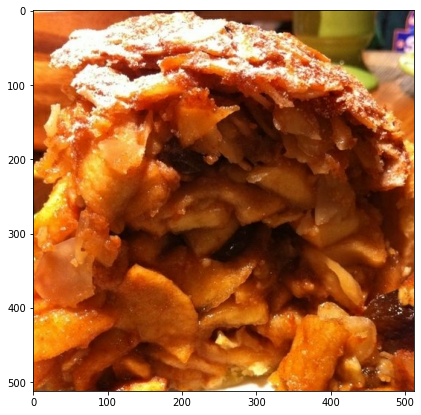

label: 0
Image shape: (343, 512, 3)
<dtype: 'uint8'>


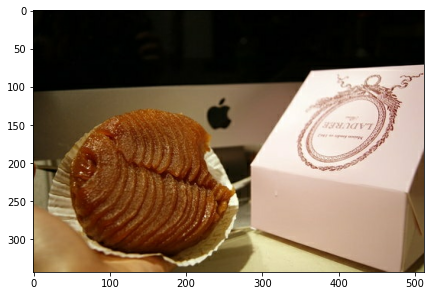

label: 0
Image shape: (358, 512, 3)
<dtype: 'uint8'>


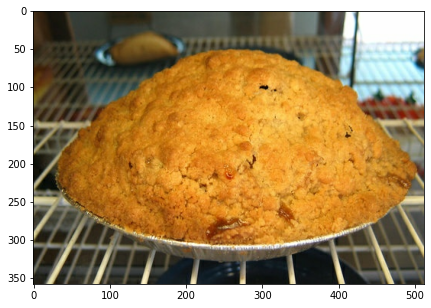

In [19]:
# visualize a few images from created TFRecord file
raw_dataset = tf.data.TFRecordDataset("./test_03-5050.tfrec")
parsed_dataset = raw_dataset.map(parse_tfrecord_fn)

for features in parsed_dataset.take(3):
    for key in features.keys():
        if key != "image":
            print(f"{key}: {features[key]}")

    print(f"Image shape: {features['image'].shape}")
    print(features['image'].dtype)
    plt.figure(figsize=(7, 7))
    plt.imshow(features["image"].numpy())
    plt.show()